(api_quickstart)=
# General API quickstart

:::{post} May 31, 2022
:tags:
:category: beginner
:author: Christian Luhmann
:::

In [45]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

In [46]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 1. Model creation

Models in PyMC are centered around the `Model` class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a `with` context:

In [47]:
with pm.Model() as model:
    # Model definition
    pass

We discuss RVs further below but let's create a simple model to explore the `Model` class.

In [48]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

In [49]:
model.basic_RVs

[mu, obs]

In [50]:
model.free_RVs

[mu]

In [51]:
model.observed_RVs

[obs]

In [52]:
model.compile_logp()({"mu": 0})

array(-143.03962875)

It's worth highlighting the design choice we made with `logp`.  As you can see above, `logp` is being called with arguments, so it's a method of the model instance. More precisely, it puts together a function based on the current state of the model -- or on the state given as argument to `logp` (see example below).

For diverse reasons, we assume that a `Model` instance isn't static. If you need to use `logp` in an inner loop and it needs to be static, simply use something like `logp = model.logp`. Here is an example below -- note the caching effect and the speed up:

In [53]:
%timeit model.compile_logp()({"mu": 0.1})
logp = model.compile_logp()
%timeit logp({"mu": 0.1})

209 ms ± 85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.3 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## 2. Probability Distributions

Every probabilistic program consists of observed and unobserved Random Variables (RVs). Observed RVs are defined via likelihood distributions, while unobserved RVs are defined via prior distributions. In the PyMC module, the structure for probability distributions looks like this:

{ref}`pymc:api_distributions`
- {ref}`pymc:api_distributions_continuous`
- {ref}`pymc:api_distributions_discrete`
- {ref}`pymc:api_distributions_multivariate`
- {ref}`pymc:api_distributions_mixture`
- {ref}`pymc:api_distributions_timeseries`
- {ref}`pymc:api_distributions_censored`
- {ref}`pymc:api_distributions_simulator`

### Unobserved Random Variables

Every unobserved RV has the following calling signature: name (str), parameter keyword arguments. Thus, a normal prior can be defined in a model context like this:

In [54]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

As with the model, we can evaluate its logp:

In [55]:
pm.logp(x, 0).eval()

array(-0.91893853)

### Observed Random Variables

Observed RVs are defined just like unobserved RVs but require data to be passed into the `observed` keyword argument:

In [56]:
with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=rng.standard_normal(100))

`observed` supports lists, `numpy.ndarray` and `pytensor` data structures.

### Deterministic transforms

PyMC allows you to freely do algebra with RVs in all kinds of ways:

In [57]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

Though these transformations work seamlessly, their results are not stored automatically. Thus, if you want to keep track of a transformed variable, you have to use `pm.Deterministic`:

In [58]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

Note that `plus_2` can be used in the identical way to above, we only tell PyMC to keep track of this RV for us.

### Lists of RVs / higher-dimensional RVs

Above we have seen how to create scalar RVs. In many models, we want multiple RVs. Users will sometimes try to create lists of RVs, like this:

In [59]:
with pm.Model():
    # bad:
    x = [pm.Normal(f"x_{i}", mu=0, sigma=1) for i in range(10)]

This works, but it is slow and not recommended. Instead, we can use {ref}`coordinates <pymc:dimensionality>`:

In [60]:
coords = {"cities": ["Santiago", "Mumbai", "Tokyo"]}
with pm.Model(coords=coords) as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, dims="cities")

`x` is now a array of length 3 and each of the 3 variables within this array is associated with a label.  This will make it very easy to distinguish the 3 different variables when we go to look at results. We can index into this array or do linear algebra operations on it:

In [61]:
with model:
    y = x[0] * x[1]  # indexing is supported
    x.dot(x.T)  # linear algebra is supported

### Initialize Random Variables

Though PyMC automatically initializes models, it is sometimes helpful to define initial values for RVs. This can be done via the `initval` kwarg:

In [62]:
with pm.Model(coords={"idx": np.arange(5)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx")

model.initial_point()

{'x': array([0., 0., 0., 0., 0.])}

In [63]:
with pm.Model(coords={"idx": np.arange(5)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx", initval=rng.standard_normal(5))

model.initial_point()

{'x': array([-0.36012097, -0.16168135,  1.07485641, -0.08855632, -0.03857412])}

This technique is sometimes useful when trying to identify problems with model specification or initialization.

## 3. Inference

Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC supports two broad classes of inference: sampling and variational inference.

### 3.1 Sampling

The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s).  `pm.sample()` returns an `arviz.InferenceData` object. `InferenceData` objects can easily be saved/loaded from a file and can carry additional (meta)data such as date/version and posterior predictive samples. Take a look at the {ref}`ArviZ Quickstart <arviz:quickstart>` to learn more.

In [64]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

    idata = pm.sample(2000)

Output()

As you can see, with model that exclusively contains continuous variables, PyMC assigns the NUTS sampler, which is very efficient even for complex models. PyMC also runs initial tuning to find good starting parameters for the sampler. Here we draw 2000 samples from the posterior in each chain and allow the sampler to adjust its parameters in an additional 1500 iterations.

If not set via the `chains` kwarg, the number of chains is determined from the number of available CPU cores.

In [65]:
idata.posterior.dims

FrozenMappingWarningOnValuesAccess({'chain': 2, 'draw': 2000})

The tuning samples are discarded by default. With `discard_tuned_samples=False` they can be kept and end up in a separate group within the `InferenceData` object (i.e., `idata.warmup_posterior`).

You can control how the chains are run in parallel using the `chains` and `cores` kwargs:

In [66]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=rng.standard_normal(100))

    idata = pm.sample(cores=4, chains=6)

Output()

In [67]:
idata.posterior["mu"].shape

(6, 1000)

In [68]:
# get values of a single chain
idata.posterior["mu"].sel(chain=2).shape

(1000,)

### 3.2 Analyze sampling results

The most common used plot to analyze sampling results is the so-called trace-plot:

In [69]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    idata = pm.sample()

Output()

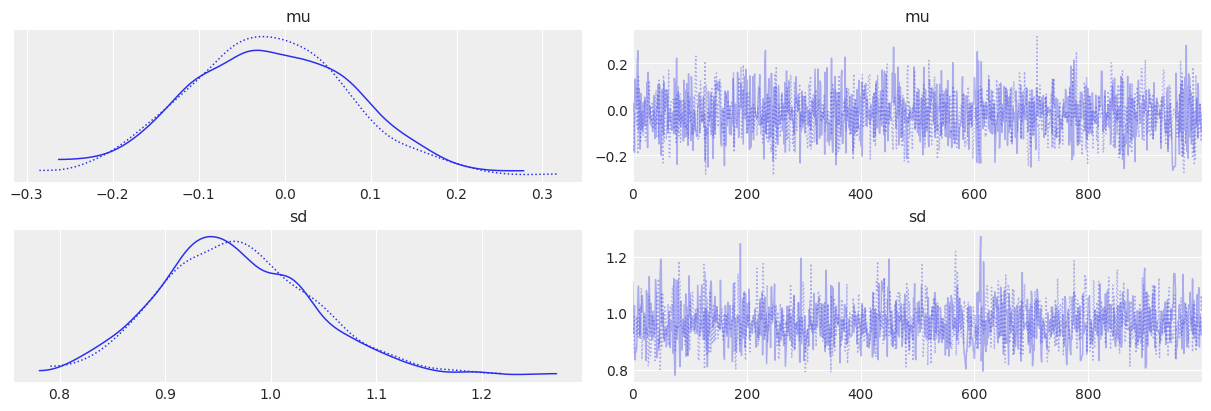

In [70]:
az.plot_trace(idata);

Another common metric to look at is the Gelman-Rubin statistic, or R-hat:

In [71]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.019,0.095,-0.189,0.166,0.002,0.002,1753.0,1064.0,1.0
sd,0.967,0.072,0.831,1.099,0.002,0.002,1551.0,1387.0,1.0


R-hat is also presented as part of the `az.plot_forest`:

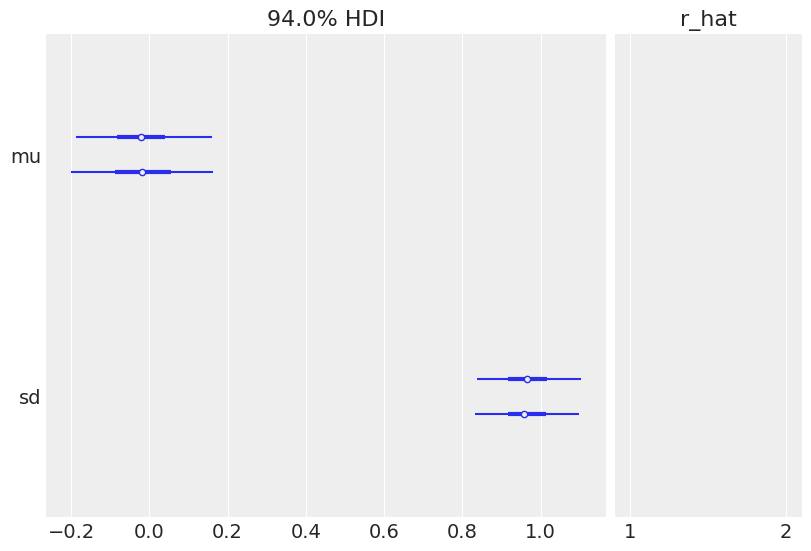

In [72]:
az.plot_forest(idata, r_hat=True);

Finally, for a plot of the posterior that is inspired by {cite:p}`kruschke2014doing`, you can use the:

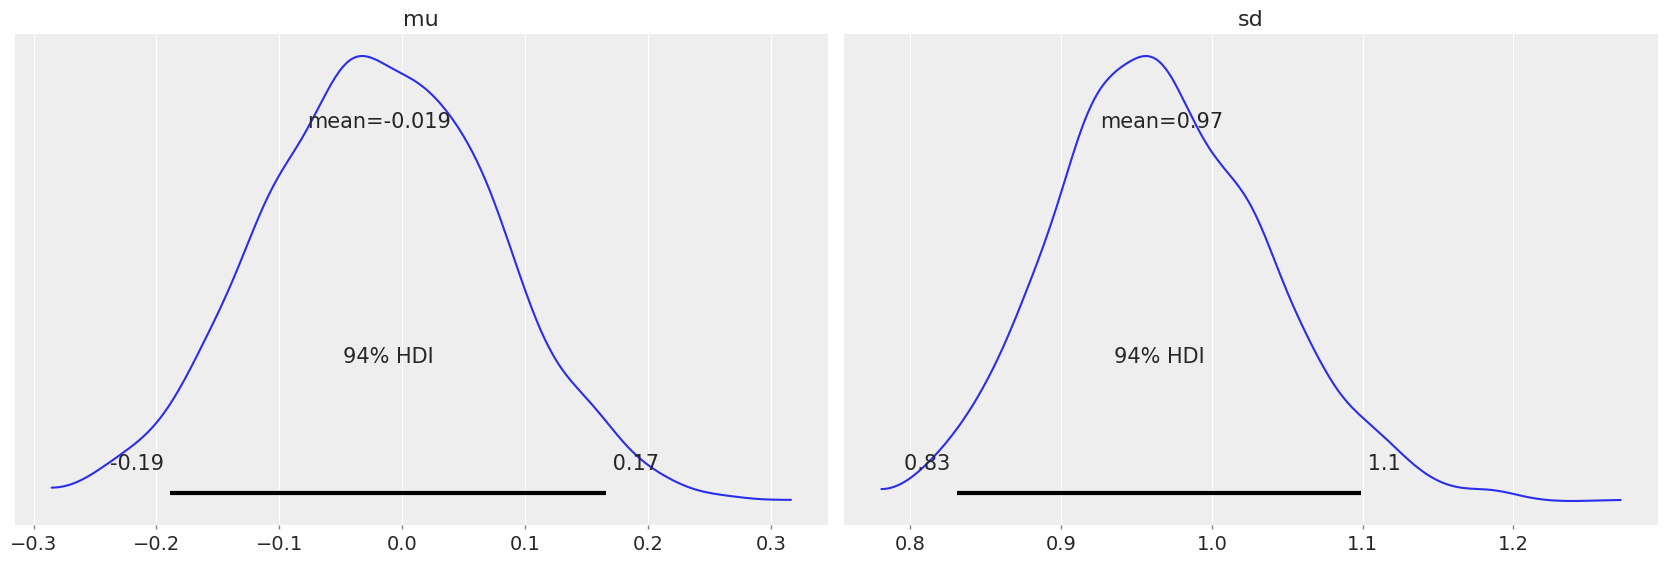

In [73]:
az.plot_posterior(idata);

For high-dimensional models it becomes cumbersome to look at the traces for all parameters. When using `NUTS` we can look at the energy plot to assess problems of convergence:

Output()

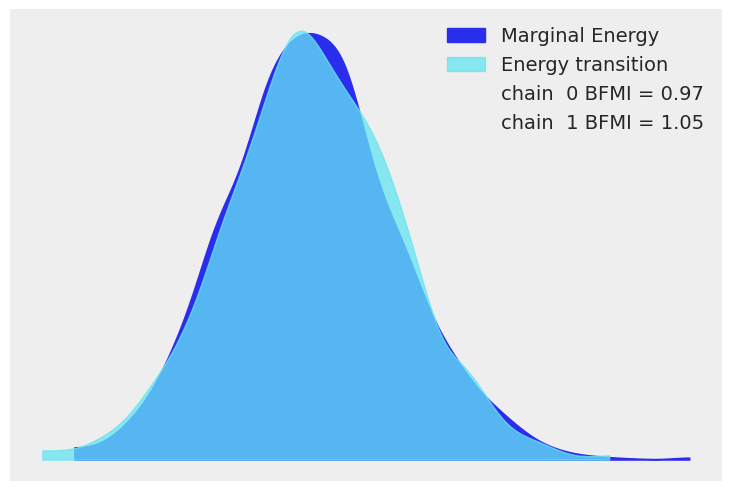

In [74]:
with pm.Model(coords={"idx": np.arange(100)}) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="idx")
    idata = pm.sample()

az.plot_energy(idata);

For more information on sampler stats and the energy plot, see {ref}`sampler_stats`. For more information on identifying sampling problems and what to do about them, see {ref}`diagnosing_with_divergences`.

### 3.3 Variational inference

PyMC supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is `pymc.fit()`.

In [75]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=rng.standard_normal(100))

    approx = pm.fit()

Output()

The returned `Approximation` object has various capabilities, like drawing samples from the approximated posterior, which we can analyse like a regular sampling run:

In [76]:
idata = approx.sample(1000)
az.summary(idata)

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.035,0.171,-0.326,0.289,0.005,0.004,1026.0,1016.0,NaN
sd,0.993,0.143,0.716,1.237,0.004,0.003,1092.0,990.0,NaN


The `variational` submodule offers a lot of flexibility in which VI to use and follows an object oriented design. For example, full-rank ADVI estimates a full covariance matrix:

In [77]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model(coords={"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu=mu, cov=cov, dims="idx")
    approx = pm.fit(method="fullrank_advi")

Output()

An equivalent expression using the object-oriented interface is:

In [78]:
with pm.Model(coords={"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu=mu, cov=cov, dims="idx")
    approx = pm.FullRankADVI().fit()

Output()

In [79]:
with pm.Model(coords={"idx": np.arange(2)}) as model:
    pm.MvNormal("x", mu=mu, cov=cov, dims="idx")
    approx = pm.FullRankADVI().fit()

Output()

<Figure size 720x480 with 0 Axes>

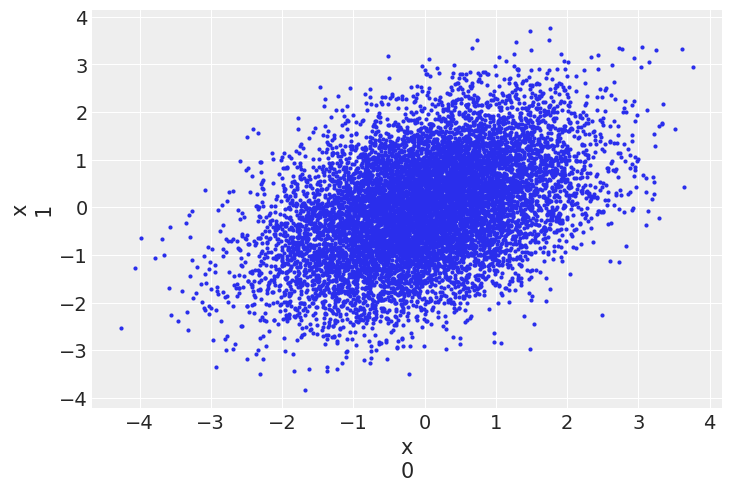

In [80]:
plt.figure()
idata = approx.sample(10000)
az.plot_pair(idata, var_names="x", coords={"idx": [0, 1]});

Stein Variational Gradient Descent (SVGD) uses particles to estimate the posterior:

In [81]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])
with pm.Model() as model:
    pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.0))

Output()

In [82]:
with pm.Model() as model:
    pm.NormalMixture("x", w=[0.2, 0.8], mu=[-0.3, 0.5], sigma=[0.1, 0.1])

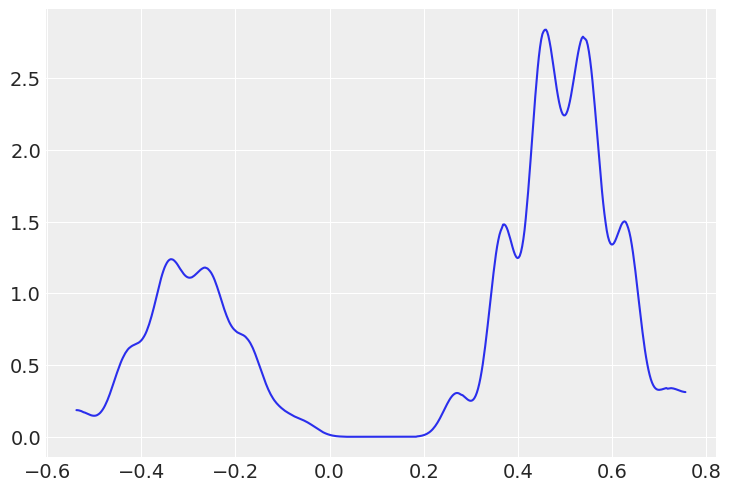

In [83]:
plt.figure()
idata = approx.sample(10000)
az.plot_dist(idata.posterior["x"]);

For more information on variational inference, see {ref}`variational_inference`.

## 4. Posterior Predictive Sampling

The `sample_posterior_predictive()` function performs prediction on hold-out data and posterior predictive checks.

In [84]:
data = rng.standard_normal(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample()

Output()

In [85]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Output()

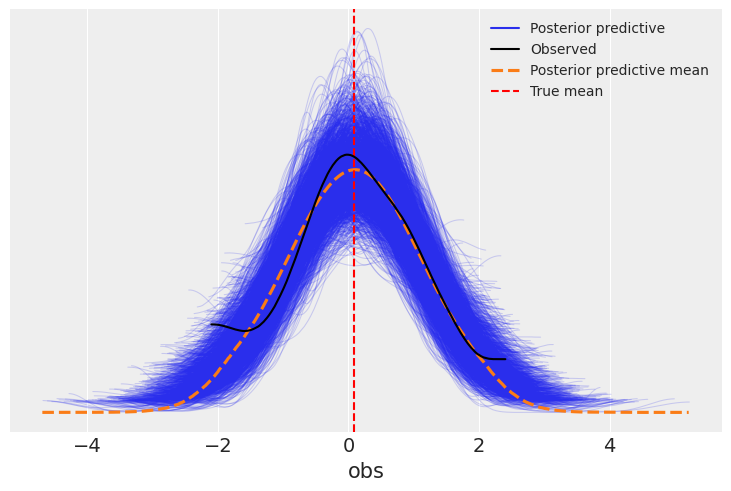

In [86]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

## 4.1 Predicting on hold-out data

In many cases you want to predict on unseen / hold-out data. This is especially relevant in Probabilistic Machine Learning and Bayesian Deep Learning. PyMC includes a `pm.MutableData` container to help with such uses. It is a wrapper around a `pytensor.shared` variable and allows the values of the data to be changed later. Otherwise, `pm.MutableData` objects can be used just like any other numpy array or tensor.

This distinction is significant since internally all models in PyMC are giant symbolic expressions. When you pass raw data directly into a model, you are giving PyTensor permission to treat this data as a constant and optimize it away if doing so makes sense. If you need to change this data later you may not have any way to point at it within the larger symbolic expression. Using `pm.MutableData` offers a way to point to a specific place in the symbolic expression and change what is there.

In [88]:
x = rng.standard_normal(100)
y = x > 0

coords = {"idx": np.arange(100)}
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_obs = pm.Data("x_obs", x, dims="idx")
    y_obs = pm.Data("y_obs", y, dims="idx")


    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_obs)
    pm.Bernoulli("obs", p=logistic, observed=y_obs, dims="idx")
    idata = pm.sample()

Output()

Now assume we want to predict on unseen data. For this we have to change the values of `x_obs` and `y_obs`. Theoretically we don't need to set `y_obs` as we want to predict it but it has to match the shape of `x_obs`.

In [ ]:
with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        },
        coords={"idx": [1001, 1002, 1003]},
    )

    idata.extend(pm.sample_posterior_predictive(idata))

In [ ]:
idata.posterior_predictive["obs"].mean(dim=["draw", "chain"])

## References

:::{bibliography}
:filter: docname in docnames
:::

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

:::{include} ../page_footer.md
:::